## NBA Position Predictor Project

### Created 16 November 2021

## Initial Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from get_stats import *

In [2]:
data = get_full_dataframe()

In [3]:
stats_df = data

In [4]:
stats_df.describe()

,RANK,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,...,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year
count,0.0,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,...,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000,1273.000000
mean,NaN,27.125656,13.745483,21.225923,44.213668,18.574784,10.097296,28.725059,0.679734,69.606441,...,10.039434,1.955381,12.853731,0.640896,0.413771,1.130833,6.400707,107.258052,103.500786,2019.541241
std,NaN,4.255849,10.110768,10.536115,21.956579,6.421486,7.515644,38.431326,0.279979,83.768229,...,5.082547,1.990470,10.158052,0.498527,0.458730,0.970946,2.859453,22.428275,6.424841,1.490031
min,NaN,19.000000,1.000000,4.000000,8.300000,4.400000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.700000,2017.000000
25%,NaN,23.660000,5.000000,12.000000,25.000000,13.900000,5.500000,4.000000,0.600000,12.000000,...,6.400000,0.600000,6.200000,0.250000,0.090000,0.440000,5.000000,97.900000,99.900000,2018.000000
50%,NaN,26.890000,11.000000,21.000000,43.700000,17.700000,10.200000,14.000000,0.750000,36.000000,...,9.000000,1.300000,10.000000,0.540000,0.290000,0.860000,6.400000,108.700000,103.900000,2020.000000
75%,NaN,30.000000,22.000000,30.500000,63.500000,22.300000,14.300000,37.000000,0.857000,93.000000,...,12.800000,2.600000,17.700000,1.000000,0.570000,1.500000,8.000000,117.900000,107.700000,2021.000000
max,NaN,41.560000,36.000000,41.900000,87.300000,48.000000,50.000000,288.000000,1.000000,493.000000,...,46.000000,12.200000,76.900000,3.000000,4.000000,5.170000,17.400000,280.100000,121.500000,2021.000000


In [5]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1273 entries, 3 to 1439
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RANK    0 non-null      float64
 1   NAME    1273 non-null   object 
 2   TEAM    1273 non-null   object 
 3   POS     1273 non-null   object 
 4   AGE     1273 non-null   float64
 5   GP      1273 non-null   int64  
 6   MPG     1273 non-null   float64
 7   MIN%    1273 non-null   float64
 8   USG%    1273 non-null   float64
 9   TO%     1273 non-null   float64
 10  FTA     1273 non-null   int64  
 11  FT%     1273 non-null   float64
 12  2PA     1273 non-null   int64  
 13  2P%     1273 non-null   float64
 14  3PA     1273 non-null   int64  
 15  3P%     1273 non-null   float64
 16  eFG%    1273 non-null   float64
 17  TS%     1273 non-null   float64
 18  PPG     1273 non-null   float64
 19  RPG     1273 non-null   float64
 20  TRB%    1273 non-null   float64
 21  APG     1273 non-null   float64
 22  

In [6]:
#divide the data into the input 'X' and the labels 'y'
X        = stats_df[['MIN%', 'USG%', 'TO%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG',
                     'RPG', 'TRB%','APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG']] #the observations
y        = stats_df['POS'] #the label

In [7]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=6, stratify = y)
# Enter appropriate values to partition data, and ensure results are reproducible and obtain stratified samples

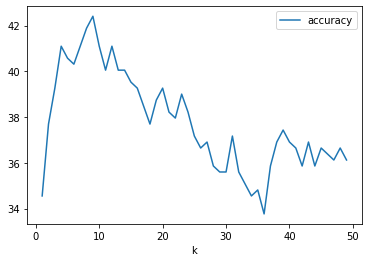

In [8]:
k = []
accuracy = []
# build the k-nn model, experiment with different values of k and plot the results
for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    k.append(i)
    accuracy.append(knn.score(X_test, y_test)*100)
    # print(knn.predict(X_test))
    # print('The accuracy of the model is {}'.format(knn.score(X_test, y_test)))
    
    
acc = pd.DataFrame({'k': k, 'accuracy': accuracy})
lines = acc.plot.line(x = 'k')

In [9]:
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.36      0.34      0.35        35
         C-F       0.29      0.15      0.20        13
           F       0.33      0.57      0.42        95
         F-C       0.25      0.05      0.08        22
         F-G       0.00      0.00      0.00        13
           G       0.54      0.71      0.61       126
         G-F       1.00      0.10      0.18        31
          PF       0.00      0.00      0.00        11
          PG       1.00      0.08      0.14        13
          SF       0.00      0.00      0.00        11
          SG       0.00      0.00      0.00        12

    accuracy                           0.42       382
   macro avg       0.34      0.18      0.18       382
weighted avg       0.43      0.42      0.37       382

